觀察證券交易所 -> 產品服務 -> ETF -> ETF收益分配
沒有可以直接下載的CSV
所以使用爬蟲 將所想要研究的資料 爬取下來

In [1]:
# 載入相關套件
from urllib.parse import urlencode, urljoin
from datetime import datetime
import requests
import pandas as pd
from pandas.core.frame import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.font_manager import FontProperties
from matplotlib.dates import DateFormatter, YearLocator

/Users/williamtseng/Documents/side_project/pjenv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def get_etf_dividend(
    #  ETF 的代號（symbol）、開始日期（start_date）和結束日期（end_date）
    symbol: str = "",
    start_date: str = "20050101",
    end_date: str = datetime.now().strftime("%Y%m%d"))->dict:
    base_url="https://www.twse.com.tw/rwd/zh/ETF/etfDiv"
    parmas={
        "stkNo" : symbol,
        "startDate" : start_date,
        "endDate" : end_date,
        "response" : "json"
        }
    query_string = f'?{urlencode(parmas)}'
    res = requests.get(urljoin(base_url, query_string))

    if res.status_code == 200:
        return res.json()
    else:
        raise Exception(f'Get data fail. {res.text}')
    
data = get_etf_dividend()


將抓取到的資料從dict用pandas 整理成DataFrame

In [3]:
def fields_and_data (source: dict)-> DataFrame:
    fields = source.get("fields")
    data = source.get ("data")
    output = {}
    for index, row in enumerate(data):
        output.setdefault(
            index, {
                i : j
                for i, j in zip(fields, row)
            }
        )

    df = pd.DataFrame(output).T
    return df

df=fields_and_data(data)
print(df.head())

     證券代號      證券簡稱       除息交易日     收益分配基準日     收益分配發放日 收益分配金額 (每1受益權益單位)  \
0   00690  兆豐臺灣藍籌30  112年11月21日  112年11月27日  112年12月14日               1.0   
1   00731  復華富時高息低波  112年11月21日  112年11月27日  112年12月15日               1.1   
2   00929  復華台灣科技優息  112年11月21日  112年11月27日  112年12月15日              0.11   
3  00775B  新光投等債15+  112年11月20日  112年11月26日  112年12月15日              0.35   
4  00775B  新光投等債15+  112年11月20日  112年11月26日  112年12月15日              0.35   

                                   收益分配標準 (102年度起啟用) 公告年度  
0  本基金可分配收益，除應符合下列規定外，並應經金管會核准辦理公開發行公司之簽證會計師查核簽證後...  112  
1  1.本基金投資中華民國境內所得之下列各款收益，做為本基金之可分配收益：(1)\t除息交易日前...  112  
2  1.本基金投資中華民國境內所得之下列各款收益，做為本基金之可分配收益：(1)除息交易日前（不...  112  
3  本基金可分配收益，除應符合下列規定外，並應經金管會核准辦理公開發行公司之簽證會計師查核簽證後...  112  
4  本基金可分配收益，除應符合下列規定外，並應經金管會核准辦理公開發行公司之簽證會計師查核簽證後...  112  


把欄位改成英文,並只留下證券代號、證券簡稱、除息交易日、收益分配發放日 以及 收益分配金額 (每1受益權益單位)

In [4]:
def ad_date(v: str) -> datetime:
    return datetime.strptime(
        f'{int(v[0:3])+1911}-{v[4:6]}-{v[7:9]}', 
        '%Y-%m-%d',
    )

def customize_info_table(df: DataFrame) -> DataFrame:
    # 創建一個空的 DataFrame
    dividend_df = pd.DataFrame()

    fields_change_to_en = {
        '證券代號': 'symbol',
        '證券簡稱': 'short_name',
        '除息交易日': 'ex_dividend_date',
        '收益分配基準日': 'dividend_based_date',
        '收益分配發放日': 'dividend_receive_date',
        '收益分配金額 (每1受益權益單位)': 'dividend_amount',
        '收益分配標準 (102年度起啟用)': 'dividend_detail',
        '公告年度': 'year'
    }
    
    # 重命名列
    df.rename(columns=fields_change_to_en, inplace=True)
    
    # 將 'ex_dividend_date' 和 'dividend_receive_date' 列應用 ad_date 函數
    df['ex_dividend_date'] = df['ex_dividend_date'].apply(ad_date)
    df['dividend_receive_date'] = df['dividend_receive_date'].apply(ad_date)
                                                          
    required_fields = [
        'symbol',
        'ex_dividend_date',
        'dividend_receive_date',
        'dividend_amount',
    ]
    
    # 選取需要的列
    dividend_df = df[required_fields].copy()

    return dividend_df

dividend_df = customize_info_table(df)
print(dividend_df)

# dividend_df.to_csv('etf_dividend.csv', index=False)


     symbol ex_dividend_date dividend_receive_date dividend_amount
0     00690       2023-11-21            2023-12-14             1.0
1     00731       2023-11-21            2023-12-15             1.1
2     00929       2023-11-21            2023-12-15            0.11
3    00775B       2023-11-20            2023-12-15            0.35
4    00775B       2023-11-20            2023-12-15            0.35
..      ...              ...                   ...             ...
604    0051       2007-11-23            2007-12-28            0.77
605    0054       2007-11-23            2007-12-28            0.35
606    0050       2007-10-24            2007-12-03             2.5
607    0050       2006-10-26            2006-12-01             4.0
608    0050       2005-05-19            2005-06-13            1.85

[609 rows x 4 columns]


挑選  0050 & 0056 做為比較

In [5]:
# 分別取出0050 0056歷史配息資料
df_0050_dividend = dividend_df[dividend_df['symbol'] == '0050']
df_0056_dividend = dividend_df[dividend_df['symbol'] == '0056']
# Print 配息資料作觀察
print("0050的配息資訊：")
print(df_0050_dividend)
print("=============================\n")
print("0056的配息資訊：")
print(df_0056_dividend)

0050的配息資訊：
    symbol ex_dividend_date dividend_receive_date dividend_amount
63    0050       2023-07-18            2023-08-11             1.9
125   0050       2023-01-30            2023-03-07             2.6
185   0050       2022-07-18            2022-08-19             1.8
218   0050       2022-01-21            2022-03-04             3.2
272   0050       2021-07-21            2021-08-24            0.35
299   0050       2021-01-22            2021-03-09            3.05
345   0050       2020-07-21            2020-08-24             0.7
367   0050       2020-01-31            2020-03-06             2.9
407   0050       2019-07-19            2019-08-22             0.7
429   0050       2019-01-22            2019-03-08             2.3
462   0050       2018-07-23            2018-08-27             0.7
473   0050       2018-01-29            2018-03-13             2.2
492   0050       2017-07-31            2017-08-31             0.7
497   0050       2017-02-08            2017-03-14             1.7

由於證交所的個股日成交資訊從2010年1月4日提供，且分月份存放，Yahoo finance則從2008年起的資料,故採用Yahoo finance現成收盤資訊，存成CSV檔 並用pandas套件讀取

In [6]:
#讀取csv檔案
df = pd.read_csv("0050.TW.csv", parse_dates=["Date"])
price_0050_df = df[["Date", "Close"]].dropna().copy()
price_0050_df.head()


,Date,Close
0,2008-01-02,60.009998
1,2008-01-03,58.889999
2,2008-01-04,59.009998
3,2008-01-07,56.389999
4,2008-01-08,56.980000


In [7]:
df = pd.read_csv("0056.TW.csv", parse_dates=["Date"])
price_0056_df = df[["Date", "Close"]].dropna().copy()
price_0056_df.head()

,Date,Close
0,2008-01-02,25.700001
1,2008-01-03,25.230000
2,2008-01-04,25.510000
3,2008-01-07,24.850000
4,2008-01-08,25.379999


回測假設：以當天收盤價價為買入成本，以定期定股方式作為交易，若設定之交易日遇休假日則往後順延

In [8]:
#擷取年-月份資料
year_month = pd.to_datetime(df['Date']).dt.strftime('%Y-%m')
year_month = sorted(list(year_month.drop_duplicates()))

year_month

['2008-01',
 '2008-02',
 '2008-03',
 '2008-04',
 '2008-05',
 '2008-06',
 '2008-07',
 '2008-08',
 '2008-09',
 '2008-10',
 '2008-11',
 '2008-12',
 '2009-01',
 '2009-02',
 '2009-03',
 '2009-04',
 '2009-05',
 '2009-06',
 '2009-07',
 '2009-08',
 '2009-09',
 '2009-10',
 '2009-11',
 '2009-12',
 '2010-01',
 '2010-02',
 '2010-03',
 '2010-04',
 '2010-05',
 '2010-06',
 '2010-07',
 '2010-08',
 '2010-09',
 '2010-10',
 '2010-11',
 '2010-12',
 '2011-01',
 '2011-02',
 '2011-03',
 '2011-04',
 '2011-05',
 '2011-06',
 '2011-07',
 '2011-08',
 '2011-09',
 '2011-10',
 '2011-11',
 '2011-12',
 '2012-01',
 '2012-02',
 '2012-03',
 '2012-04',
 '2012-05',
 '2012-06',
 '2012-07',
 '2012-08',
 '2012-09',
 '2012-10',
 '2012-11',
 '2012-12',
 '2013-01',
 '2013-02',
 '2013-03',
 '2013-04',
 '2013-05',
 '2013-06',
 '2013-07',
 '2013-08',
 '2013-09',
 '2013-10',
 '2013-11',
 '2013-12',
 '2014-01',
 '2014-02',
 '2014-03',
 '2014-04',
 '2014-05',
 '2014-06',
 '2014-07',
 '2014-08',
 '2014-09',
 '2014-10',
 '2014-11',
 '20

假設每個月月中15號，投入固定張數，列出交易日期
由於0050及0056歷史夠悠久，且在同一交易市場中，故交易日期應為同一天

In [9]:
#設定每月15號投入固定張數
TRADE_DATE=15

trade_list=[]
for i in range(len(year_month)):
        # filter each month price data
    year, month = year_month[i].split('-')
    month_df = df[
        (df['Date'].dt.year == int(year)) & \
        (df['Date'].dt.month == int(month))
    ]
 
    # 遇假日順延
    month_df = month_df[month_df['Date'].dt.day >= TRADE_DATE]
 
    if len(month_df) > 0:
        
        # select the first trade date
        trade_date = month_df.iloc[0, :].Date
        trade_list.append(trade_date)

print(trade_list)

[Timestamp('2008-01-15 00:00:00'), Timestamp('2008-02-15 00:00:00'), Timestamp('2008-03-17 00:00:00'), Timestamp('2008-04-15 00:00:00'), Timestamp('2008-05-15 00:00:00'), Timestamp('2008-06-16 00:00:00'), Timestamp('2008-07-15 00:00:00'), Timestamp('2008-08-15 00:00:00'), Timestamp('2008-09-15 00:00:00'), Timestamp('2008-10-15 00:00:00'), Timestamp('2008-11-17 00:00:00'), Timestamp('2008-12-15 00:00:00'), Timestamp('2009-01-15 00:00:00'), Timestamp('2009-02-16 00:00:00'), Timestamp('2009-03-16 00:00:00'), Timestamp('2009-04-15 00:00:00'), Timestamp('2009-05-15 00:00:00'), Timestamp('2009-06-15 00:00:00'), Timestamp('2009-07-15 00:00:00'), Timestamp('2009-08-17 00:00:00'), Timestamp('2009-09-15 00:00:00'), Timestamp('2009-10-15 00:00:00'), Timestamp('2009-11-16 00:00:00'), Timestamp('2009-12-15 00:00:00'), Timestamp('2010-01-15 00:00:00'), Timestamp('2010-02-22 00:00:00'), Timestamp('2010-03-15 00:00:00'), Timestamp('2010-04-15 00:00:00'), Timestamp('2010-05-17 00:00:00'), Timestamp('20

假設每次買入股數為1000股(1張)

In [10]:
#每次買入1000股
def calculate_investments(df, trade_list, invest_unit=1000):
    output_df = df.copy()

    output_df['buy'] = np.where(output_df['Date'].isin(trade_list), 1, 0)
    output_df['share'] = np.where(output_df['buy'], invest_unit, 0)
    output_df['cost'] = np.where(output_df['buy'], invest_unit * output_df['Close'], 0)

    output_df['total_shares'] = output_df['share'].cumsum()
    output_df['total_cost'] = output_df['cost'].cumsum()

    output_df['stock_value'] = output_df['total_shares'] * output_df['Close']

    return output_df

result_0050_df = calculate_investments(price_0050_df, trade_list)

result_0056_df = calculate_investments(price_0056_df, trade_list)


將配息時間與投資記錄合併

In [11]:
def merge_and_fill_dividend(result_df, dividend_df):
    # 將 'Date' 欄位轉換為 datetime 格式
    result_df['Date'] = pd.to_datetime(result_df['Date'])
    dividend_df['ex_dividend_date'] = pd.to_datetime(dividend_df['ex_dividend_date'])


    # 可以選擇性地將 "dividend_receive_date" 從原始 DataFrame 中刪除
    dividend_df = dividend_df.drop('dividend_receive_date', axis=1)

    merged_df = result_df.merge(dividend_df, how='left', left_on='Date', right_on='ex_dividend_date', suffixes=('_result', '_dividend'))

    # 新增 'ex_dividend_date' 欄位，若 'ex_dividend_date' 與 'Date' 相同，則為 1，否則為 0
    merged_df['ex_dividend_date'] = np.where(merged_df['ex_dividend_date'].dt.date == merged_df['Date'].dt.date, 1, 0)

    # 新增 'dividend_amount' 欄位，若 'ex_dividend_date' 為 1，則取 'dividend_amount' 的值，否則為 0
    merged_df['dividend_amount'] = np.where(merged_df['ex_dividend_date'] == 1, merged_df['dividend_amount'], 0)
    # 移除多餘的欄位
    merged_df = merged_df.drop('symbol', axis=1)

    return merged_df


result_0050_df_with_dividend = merge_and_fill_dividend(result_0050_df, df_0050_dividend)
result_0056_df_with_dividend = merge_and_fill_dividend(result_0056_df, df_0056_dividend)

/var/folders/hn/2_jhhlss4xq812x7hb0zcscw0000gn/T/ipykernel_3860/2290705132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dividend_df['ex_dividend_date'] = pd.to_datetime(dividend_df['ex_dividend_date'])
/var/folders/hn/2_jhhlss4xq812x7hb0zcscw0000gn/T/ipykernel_3860/2290705132.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dividend_df['ex_dividend_date'] = pd.to_datetime(dividend_df['ex_dividend_date'])


計算配息現金流量、資本利得率、配息率

In [12]:
def calculate_dividend_cash(result_df):
    result_df["dividend_cash"] = 0
    result_df["capital_gains"] = 0
    result_df["dividend_ratio"] = 0
    mask = result_df['ex_dividend_date'] == 1

    result_df['total_shares'] = pd.to_numeric(result_df['total_shares'], errors='coerce')
    result_df['dividend_amount'] = pd.to_numeric(result_df['dividend_amount'], errors='coerce')

    result_df.loc[mask, 'dividend_cash'] = result_df['total_shares'].shift(1) * result_df['dividend_amount']

    # 計算資本利得
    result_df['stock_value'] = pd.to_numeric(result_df['stock_value'], errors='coerce')
    result_df['total_cost'] = pd.to_numeric(result_df['total_cost'], errors='coerce')
    result_df['capital_gains'] = ((result_df['stock_value'] - result_df['total_cost']) / result_df['total_cost']) * 100
    
    # 計算配息率
    result_df["dividend_ratio"] =  result_df['dividend_amount'] / result_df['Close'].shift(1) 

    return result_df
 


result_0050_cash_dividend = calculate_dividend_cash(result_0050_df_with_dividend)
result_0056_cash_dividend = calculate_dividend_cash(result_0056_df_with_dividend)

# 存為 CSV 方便觀察或可以其他方式做視覺化呈現
result_0050_cash_dividend.to_csv("result_0050_cash_dividend.csv")
result_0056_cash_dividend.to_csv("result_0056_cash_dividend.csv")



/var/folders/hn/2_jhhlss4xq812x7hb0zcscw0000gn/T/ipykernel_3860/116602306.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 44000. 101200.  75400.  59500.  82000.  94000. 137800. 112100. 188500.
 255600. 246400. 298800. 373800. 187000. 228000.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result_df.loc[mask, 'dividend_cash'] = result_df['total_shares'].shift(1) * result_df['dividend_amount']


用matplotlib 繪製配息比較圖

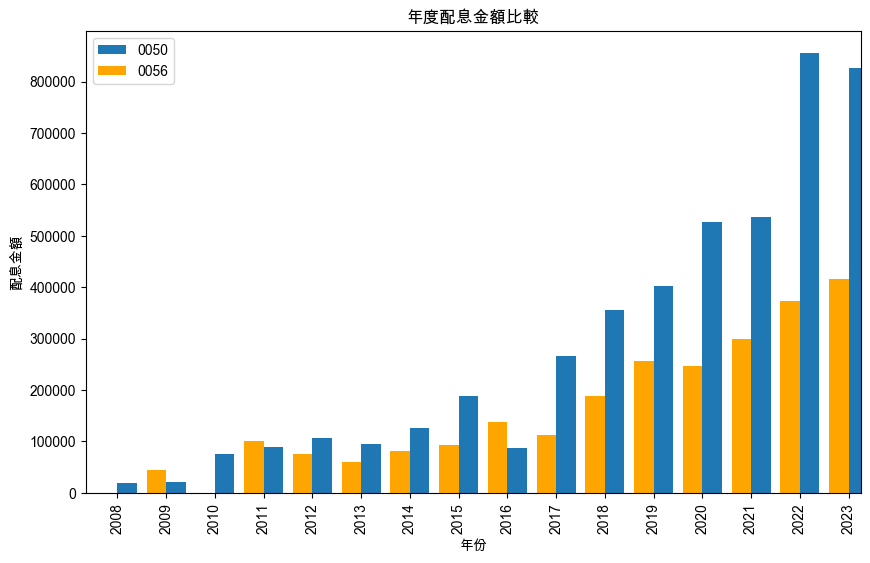

In [13]:
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 設定中文字體
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

def plot_compared_dividend(df1, df2, date_column='Date', amount_column='dividend_cash'):
    df1 = df1.copy()
    df2 = df2.copy()
    # 確保日期欄位是 datetime64 型態
    df1[date_column] = pd.to_datetime(df1[date_column])
    df1.set_index(date_column, inplace=True)

    df2[date_column] = pd.to_datetime(df2[date_column])
    df2.set_index(date_column, inplace=True)

    # 按照年度繪製配息圖

    plt.figure(figsize=(10, 6))

    df1.groupby(df1.index.year)[amount_column].sum().plot(kind='bar', position=0, width=0.4, label='0050')
    df2.groupby(df2.index.year)[amount_column].sum().plot(kind='bar', position=1, width=0.4, color='orange', label='0056')


    plt.title('年度配息金額比較')
    plt.xlabel('年份')
    plt.ylabel('配息金額')
    plt.legend()
    plt.show()


plot_compared_dividend(result_0050_cash_dividend, result_0056_cash_dividend)


配息率比較

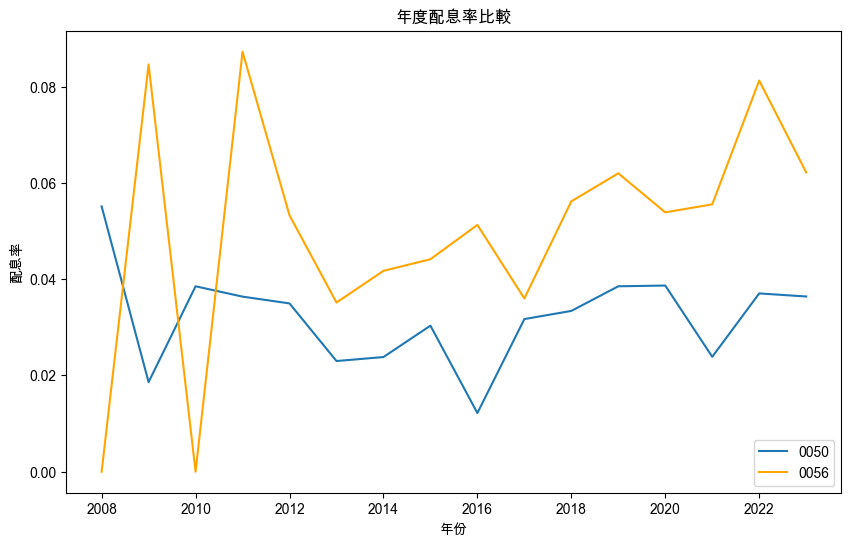

In [14]:
def plot_compared_dividend(df1, df2, date_column='Date', amount_column='dividend_ratio'):
    df1 = df1.copy()
    df2 = df2.copy()
    # 確保日期欄位是 datetime64 型態
    df1[date_column] = pd.to_datetime(df1[date_column])
    df1.set_index(date_column, inplace=True)

    df2[date_column] = pd.to_datetime(df2[date_column])
    df2.set_index(date_column, inplace=True)

    # 按照年度繪製配息圖

    plt.figure(figsize=(10, 6))

    df1.groupby(df1.index.year)[amount_column].sum().plot(kind='line', label='0050')
    df2.groupby(df2.index.year)[amount_column].sum().plot(kind='line', color='orange', label='0056')


    plt.title('年度配息率比較')
    plt.xlabel('年份')
    plt.ylabel('配息率%')
    plt.legend()
    plt.show()


plot_compared_dividend(result_0050_cash_dividend, result_0056_cash_dividend)

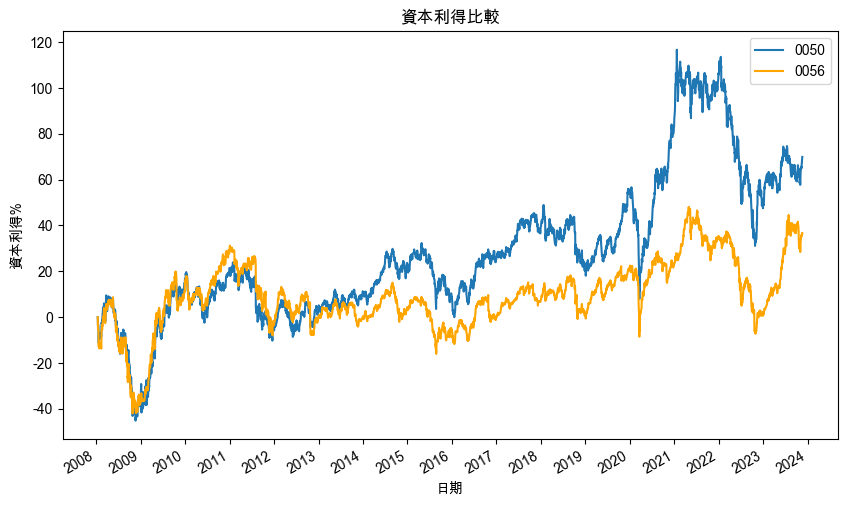

In [15]:
def plot_compared_dividend(df1, df2, date_column='Date', amount_column='capital_gains'):
    df1 = df1.copy()
    df2 = df2.copy()

    df1[date_column] = pd.to_datetime(df1[date_column])
    df1.set_index(date_column, inplace=True)

    df2[date_column] = pd.to_datetime(df2[date_column])
    df2.set_index(date_column, inplace=True)

    # 繪製資本利得折線圖

    plt.figure(figsize=(10, 6))

    df1[amount_column].plot(kind='line', label='0050')
    df2[amount_column].plot(kind='line', color='orange', label='0056')

    # 設置日期格式為年份
    date_format = DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)

    # 設置 x 軸主要刻度位置（每年標示一次）
    plt.gca().xaxis.set_major_locator(YearLocator(1))


    plt.title('資本利得比較')
    plt.xlabel('日期')
    plt.ylabel('資本利得%')
    plt.legend()
    plt.show()


plot_compared_dividend(result_0050_cash_dividend, result_0056_cash_dividend)